In [1]:
import numpy as np
import gurobipy as grb

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

# local imports
from models.svm import SoftMarginSVM

Let's load in both the training and validation datasets for sentiment analysis. These are collected airline sentiment tweets, and our goal is to create a simple binary classifier for positive/negative sentiment prediction.

In [23]:
# import training and validation data
train_path = 'data/sentiment_train.csv'
val_path = 'data/sentiment_val.csv'
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)

We build a TF-IDF (term frequency-inverse document frequency) bag-of-words vector for each training/validation tweet, with a dictionary created from our training set. We note that term frequency is defined, for term $t$ and document $d$, as
\begin{equation*}
\text{TF}(t,d) = \frac{\text{Number of times term $t$ appears in document $d$}}{\text{Total number of terms in document $d$}}
\end{equation*}

Similarly, inverse document frequency is defined, for a term $t$ and corpus $D$, as
\begin{equation*}
\text{IDF}(t,D) = \log\left( \frac{\text{Total number of documents in corpus $D$}}{\text{Number of documents containing term $t$}} \right)
\end{equation*}

Then, TF-IDF is defined as
\begin{equation*}
\text{TF-IDF}(t,d,D) = \text{TF}(t,d) \times \text{IDF}(t,D)
\end{equation*}

In [24]:
# build BoW TF-IDF feature vectorizor
vectorizor = TfidfVectorizer(stop_words='english')

# fit transform training and validation data
train_tfidf = vectorizor.fit_transform(train_data['tweet']).toarray()
val_tfidf = vectorizor.transform(val_data['tweet']).toarray()

train_labels = 2 * train_data['label'].to_numpy() - 1
val_labels = 2 * val_data['label'].to_numpy() - 1

# get word vocabulary
words = vectorizor.get_feature_names_out()

A soft-margin SVM is a linear classifier that attempts to find the line of separation between two classes that maximizes the margin of the decision boundary, which is the minimum distance between any point and the boundary. A hard-margin SVM requires all points to be correctly classified, whereas a soft-margin SVM allows incorrect classification on training points through slack variables. Formally, the primal form optimization problem for a soft-margin linear SVM with a slack constant $C$ is defined as
\begin{align*}
\min_{w,b} &\quad \frac{1}{2}\lVert w \rVert + C \sum_{i=1}^N \xi_i \\
\text{s.t.} &\quad y_i(w^\top x_i + b) \leq 1-\xi_i \\
&\quad \xi_i \geq 0
\end{align*}

We also note the dual (and kernelized) formulation of the optimization problem as
\begin{align*}
\min_\alpha &\quad \sum_{i=1}^N \sum_{j=1}^N \alpha_i\alpha_j y_i y_j K(x_i, x_j) - \sum_{i=1}^N \alpha_i \\
\text{s.t.} &\quad 0 \leq \alpha_i \leq C \\
&\quad \sum_{i=1}^N \alpha_i y_i = 0
\end{align*}

where $K$ is a valid kernel function. Here, we implement a soft-margin SVN with available linear, quadratic, and RBF kernels, allowing for non-linear decision boundaries. The implementation of this SVM class is within `/models/svm.py`. Note that both of the above implementations are quadratic programs, and can be solved efficiently with Gurobi. We can define our hyperparameters and initialize our model with the training dataset (note that because the objective function is defined over all data points, each SVM model is bespoke to the dataset we train on).

In [5]:
# hyperparameters
C = 1.0
gamma = 0.5

# construct soft margin SVM with RBF kernel
model = SoftMarginSVM(train_tfidf, train_labels, C, kernel="rbf", gamma=gamma)

Set parameter Username
Set parameter LicenseID to value 2769110
Academic license - for non-commercial use only - expires 2027-01-22


And we then optimize our model.

In [6]:
# optimize the model
model.optimize()

We can now analyze the AUROC (area under receiver operating characteristic curve) score on the training dataset. This measures a binary classifier's performance on unevenly weighted datasets. A value of $0.5$ is equivalent to random guessing, and a value of $1.0$ is equivalent to classification mastery.

In [8]:
pred_train = model.predict(train_tfidf)

# compute training AUROC score
train_auroc = metrics.roc_auc_score(train_labels, pred_train)
print(f"Training AUROC: {train_auroc:.4f}")

Training AUROC: 0.9786


We can also analyze AUROC score on the validation dataset (withheld during optimization), and determine generalization performance of our classifier.

In [9]:
pred_val = model.predict(val_tfidf)

# compute validation AUROC score
auroc = metrics.roc_auc_score(val_labels, pred_val)
print(f"Validation AUROC: {auroc:.4f}")

Validation AUROC: 0.8787


And we can test with custom real-world examples to determine the effectiveness of our model.

In [32]:
# sentence = "the movie was terrible, i would not recommend it to anyone"
sentence = "the movie was amazing, i would recommend it to everyone"

sentence_tfidf = vectorizor.transform([sentence]).toarray()
prediction = model.predict(sentence_tfidf)
print(f"Prediction for '{sentence}': {'positive' if prediction[0] == 1 else 'negative'}")

Prediction for 'the movie was amazing, i would recommend it to everyone': positive


Below is a simple 2D visualization of the kernelized SVM decision boundary with an RBF kernel on randomly sampled points.

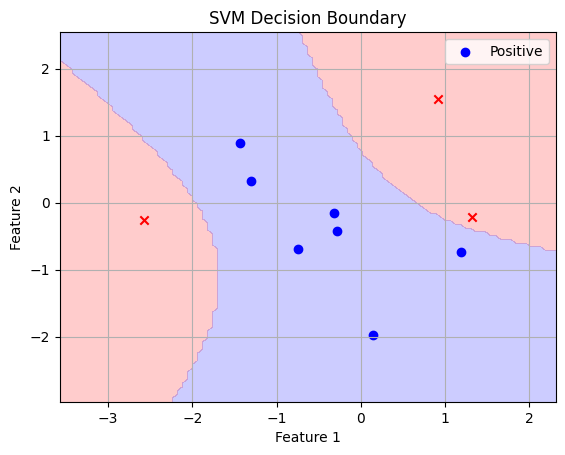

In [33]:
# randomly sample 10 2d points and labels
num_points = 10
dim = 2
points = np.random.randn(num_points, dim)
labels = np.random.choice([-1, 1], size=10)

# construct soft margin SVM with RBF kernel
svm_model = SoftMarginSVM(points, labels, C=0.01, kernel="rbf", gamma=0.5)
svm_model.optimize()

# Plotting the results
import matplotlib.pyplot as plt

# plot data points
for i in range(num_points):
    if labels[i] == 1:
        plt.scatter(points[i, 0], points[i, 1], color='blue', marker='o', label='Positive' if i == 0 else "")
    else:
        plt.scatter(points[i, 0], points[i, 1], color='red', marker='x', label='Negative' if i == 0 else "")

# create a grid to plot decision boundary
x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = svm_model.predict(grid_points)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.2, colors=['red', 'blue'])
        
# plot quadratic decision boundary

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary')
plt.legend()
plt.grid()
plt.show()